Introduction

This notebook explores the fascinating idea of embedding hierarchical data, such as linguistic or topic relationships, within the framework of Minkowski spacetime. Drawing inspiration from the paper "Minkowski spacetime embeddings for semantic hierarchy," we investigate whether the causal structure inherent in Minkowski geometry can effectively represent hierarchical parent-child relationships. The notebook demonstrates two primary approaches:

- Synthetic Hierarchy Embedding: We begin by defining a simple, manually constructed hierarchy (e.g., categories like "World" -> "Sports" -> "Football"). We then apply an iterative adjustment algorithm to find spatial (x, y) and temporal (t) coordinates in 3D Minkowski space ((x, y, t) is a simplification of the (t, x, y) or (t, x, y, z) used in the code) such that child nodes lie within the future light cone of their parent nodes. This causal relationship in spacetime geometrically encodes the hierarchical link.

- LDA-derived Topic Hierarchy Embedding: We then apply the same Minkowski embedding concept to a hierarchy derived from a real-world dataset using Latent Dirichlet Allocation (LDA). By clustering the topic-word distributions obtained from LDA, we construct a hierarchical tree of topics. This derived hierarchy is then embedded into Minkowski spacetime using the iterative adjustment process, aiming for a causal representation of the topic relationships.

Beyond embedding hierarchies, the notebook also includes a foundational exploration of Lorentz transformations in Minkowski spacetime. This section introduces the concept of four-vectors and demonstrates how boosts and rotations affect these vectors while preserving the fundamental spacetime interval. This serves as a crucial theoretical backdrop, hinting at how semantic relationships might be manipulated or understood through the lens of relativistic transformations.

Finally, the notebook includes truncated code from a third approach attempting to embed a WordNet subtree using BERT embeddings. While not fully completed in the provided code, this section illustrates the potential to combine advanced language models with Minkowski embeddings for more complex, real-world semantic hierarchies.

Through these examples, this notebook aims to provide a hands-on exploration of how the geometric properties of Minkowski space can be leveraged to represent and potentially reason about hierarchical structures in data.

## Future Research

The experiments in this notebook open several avenues for future research:

- Improved Embedding Algorithms: The iterative adjustment used here is a simplified approach. Future work could implement more sophisticated optimization techniques, potentially based on gradient descent on a loss function that penalizes causal violations, similar to the methods described in the original paper. Exploring alternative optimization landscapes and initialization strategies could lead to more robust and accurate embeddings.

- Scaling to Large Hierarchies: The current approach might become computationally expensive for very large hierarchies. Investigating methods for efficient handling of numerous nodes and edges, potentially using sparse matrix techniques or mini-batch processing during optimization, would be necessary for real-world applications.

- Higher-Dimensional Embeddings: While 3D (or 4D including time) Minkowski space is used here for visualization, exploring embeddings in higher dimensions could potentially capture more nuanced hierarchical relationships and improve embedding quality, especially for complex semantic structures.

- Evaluating Embedding Quality: Developing more rigorous quantitative metrics to evaluate the quality of the Minkowski embedding is essential. Beyond simply checking for causal connections, metrics could assess how well the spacetime distances correlate with semantic similarity or hierarchical depth.

- Applications of Lorentz Transformations: Further investigation into how Lorentz transformations can be semantically interpreted and applied to manipulate or compare embedded concepts could be a fruitful area. This could involve exploring how boosts relate to intensifying or attenuating aspects of meaning, or how rotations could represent shifts between related concepts.


- Task-Specific Evaluation: Assessing the utility of Minkowski spacetime embeddings on downstream tasks such as hierarchical classification, semantic search, or knowledge graph completion would demonstrate their practical value.

By addressing these areas, future research can build upon the foundational ideas presented in this notebook to develop powerful new methods for representing and reasoning about complex hierarchical data.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import random
import itertools

# --- Configuration ---
NUM_SPATIAL_DIMS = 2 # For (x,y,t) -> 3D Minkowski
EPSILON_CAUSAL = 1e-5 # Small value for strict causal inequality: dt**2 > dx**2 + dy**2 + EPSILON_CAUSAL
                       # Or, for the paper's approach: dt > sqrt(dx**2 + dy**2) + epsilon1

# --- Define a Simple Hierarchy ---
# (Child, Parent)
# Example: AG_NEWS categories simplified
# World -> Sports
# World -> Business
# Sports -> Football
# Sports -> Basketball
# Business -> Finance
# Business -> Tech
hierarchy_pairs = [
    ("Football", "Sports"),
    ("Basketball", "Sports"),
    ("Finance", "Business"),
    ("Tech", "Business"),
    ("Sports", "World"),
    ("Business", "World"),
    ("World", None) # Root node
]

# Extract unique nodes and create a mapping
nodes = sorted(list(set(n for pair in hierarchy_pairs for n in pair if n is not None)))
node_to_id = {name: i for i, name in enumerate(nodes)}
id_to_node = {i: name for i, name in enumerate(nodes)}
num_nodes = len(nodes)

print(f"Nodes: {nodes}")
print(f"Node to ID: {node_to_id}")

# Represent hierarchy as child_id -> parent_id
adj = {node_to_id[child]: node_to_id[parent] for child, parent in hierarchy_pairs if parent is not None}
root_id = node_to_id["World"]

print(f"Adjacency (child_id -> parent_id): {adj}")

Nodes: ['Basketball', 'Business', 'Finance', 'Football', 'Sports', 'Tech', 'World']
Node to ID: {'Basketball': 0, 'Business': 1, 'Finance': 2, 'Football': 3, 'Sports': 4, 'Tech': 5, 'World': 6}
Adjacency (child_id -> parent_id): {3: 4, 0: 4, 2: 1, 5: 1, 4: 6, 1: 6}


In [ ]:
# --- Initialize Coordinates ---
# Spatial coordinates randomly, time coordinate initially 0 (or small random for variety)
# Coords: [num_nodes, NUM_SPATIAL_DIMS + 1] -> (x, y, t)
coords = np.random.rand(num_nodes, NUM_SPATIAL_DIMS + 1) * 2 - 1 # Range -1 to 1
coords[:, -1] = 0.0 # Initialize time to 0 (or small random positive values for parents)

# --- Helper Functions for Minkowski Geometry ---
def minkowski_interval_sq(coord1, coord2):
    """Calculates squared Minkowski interval: -dt^2 + dx^2 + dy^2 (+ dz^2 ...)"""
    dt = coord1[-1] - coord2[-1]
    d_spatial_sq = np.sum((coord1[:-1] - coord2[:-1])**2)
    return -dt**2 + d_spatial_sq

def spatial_distance_sq(coord1, coord2):
    return np.sum((coord1[:-1] - coord2[:-1])**2)

def is_causally_connected(child_coord, parent_coord, strict=True):
    """Check if parent can causally influence child (parent is in past light cone of child)
       This means child_time > parent_time AND
       (child_time - parent_time)^2 > (spatial_distance)^2
    """
    dt = child_coord[-1] - parent_coord[-1]
    if dt <= 0: # Parent must be in the past
        return False

    d_spatial_sq_val = spatial_distance_sq(child_coord, parent_coord)

    # For causality: (dt)^2 > d_spatial^2  (assuming c=1)
    # dt > sqrt(d_spatial^2)
    if strict:
        return dt**2 > d_spatial_sq_val + EPSILON_CAUSAL # Ensure timelike separation
    else:
        return dt**2 >= d_spatial_sq_val # Allow lightlike

# --- Simplified Iterative Embedding Adjustment ---
# This is a very naive approach compared to the paper's sophisticated optimization.
# The paper fixes spatial coords and only adjusts time. We can try that.
# Let's fix spatial coordinates and only adjust time as per the paper's basic idea.
coords[:, :-1] = np.random.uniform(-1, 1, size=(num_nodes, NUM_SPATIAL_DIMS)) # Random spatial
coords[:, -1] = 0.0 # Initialize all times to 0

# Paper's idea: tx -> tx + delta(1-eps2), ty -> ty - delta*eps2
# where delta = Tmin - Txy, and Tmin = Dxy + eps1
# Txy = tx - ty (time difference)
# Dxy = spatial distance between X (child) and Y (parent)

MAX_ITERATIONS = 2000
LEARNING_RATE_FACTOR = 0.1 # Controls how much we push
EPSILON_1 = 1e-4 # Paper's hyperparameter (related to desired proper time)
EPSILON_2 = 0.0  # Paper's hyperparameter (0 means parent Y doesn't move due to this child X)

print("\nStarting embedding adjustment...")
for iteration in range(MAX_ITERATIONS):
    violations = 0
    total_delta_sum = 0

    # Iterate over child-parent pairs
    for child_id, parent_id in adj.items():
        child_coord = coords[child_id]
        parent_coord = coords[parent_id]

        t_child = child_coord[-1]
        t_parent = parent_coord[-1]

        d_xy_spatial = np.sqrt(spatial_distance_sq(child_coord, parent_coord))

        t_xy_current = t_child - t_parent # Current time difference
        t_min_required = d_xy_spatial + EPSILON_1 # Required time difference for causal link

        if t_xy_current < t_min_required: # Violation: child not sufficiently in future of parent
            violations += 1
            delta_t = t_min_required - t_xy_current
            total_delta_sum += delta_t

            # Adjust child's time forward, parent's time backward (if EPSILON_2 > 0)
            # Paper: tx -> tx + delta_t * (1 - EPSILON_2)
            #        ty -> ty - delta_t * EPSILON_2
            coords[child_id, -1] += delta_t * (1 - EPSILON_2) * LEARNING_RATE_FACTOR
            if EPSILON_2 > 0: # Only if parents are also adjusted
                 coords[parent_id, -1] -= delta_t * EPSILON_2 * LEARNING_RATE_FACTOR

    if iteration % 100 == 0:
        print(f"Iteration {iteration}: Violations = {violations}, Total Delta Sum = {total_delta_sum:.4f}")

    if violations == 0 and total_delta_sum < 1e-5 : # Check for small adjustments too
        print(f"Converged at iteration {iteration}!")
        break
else:
    print("Max iterations reached. May not have fully converged.")

# Ensure root node has smallest time (or adjust if necessary)
# For simplicity, we can manually push other nodes' times up if they are below root
# Or better, ensure root is never a child in `adj` and is not updated as a child.
# We can also sort by depth and initialize times based on depth.

# Post-processing: ensure root is at t=0 (or earliest time) by shifting all time coordinates
min_time_coord = np.min(coords[:, -1])
coords[:, -1] -= min_time_coord

print("\nFinal Coordinates (x, y, t):")
for i in range(num_nodes):
    print(f"{id_to_node[i]}: {coords[i]}")

# Verify causal connections
print("\nVerifying causal connections:")
for child_id, parent_id in adj.items():
    child_name = id_to_node[child_id]
    parent_name = id_to_node[parent_id]
    connected = is_causally_connected(coords[child_id], coords[parent_id])
    dt = coords[child_id, -1] - coords[parent_id, -1]
    d_spatial = np.sqrt(spatial_distance_sq(coords[child_id], coords[parent_id]))
    print(f"{child_name} -> {parent_name}: Causally OK = {connected} (dt={dt:.3f}, d_sp={d_spatial:.3f}, dt_req={d_spatial+EPSILON_1:.3f})")


Starting embedding adjustment...
Iteration 0: Violations = 6, Total Delta Sum = 6.9582
Iteration 100: Violations = 6, Total Delta Sum = 0.0015
Iteration 200: Violations = 6, Total Delta Sum = 0.0000
Iteration 300: Violations = 6, Total Delta Sum = 0.0000
Iteration 400: Violations = 6, Total Delta Sum = 0.0000
Iteration 500: Violations = 6, Total Delta Sum = 0.0000
Iteration 600: Violations = 6, Total Delta Sum = 0.0000
Iteration 700: Violations = 6, Total Delta Sum = 0.0000
Iteration 800: Violations = 6, Total Delta Sum = 0.0000
Iteration 900: Violations = 6, Total Delta Sum = 0.0000
Iteration 1000: Violations = 6, Total Delta Sum = 0.0000
Iteration 1100: Violations = 6, Total Delta Sum = 0.0000
Iteration 1200: Violations = 6, Total Delta Sum = 0.0000
Iteration 1300: Violations = 6, Total Delta Sum = 0.0000
Iteration 1400: Violations = 6, Total Delta Sum = 0.0000
Iteration 1500: Violations = 6, Total Delta Sum = 0.0000
Iteration 1600: Violations = 6, Total Delta Sum = 0.0000
Iteration

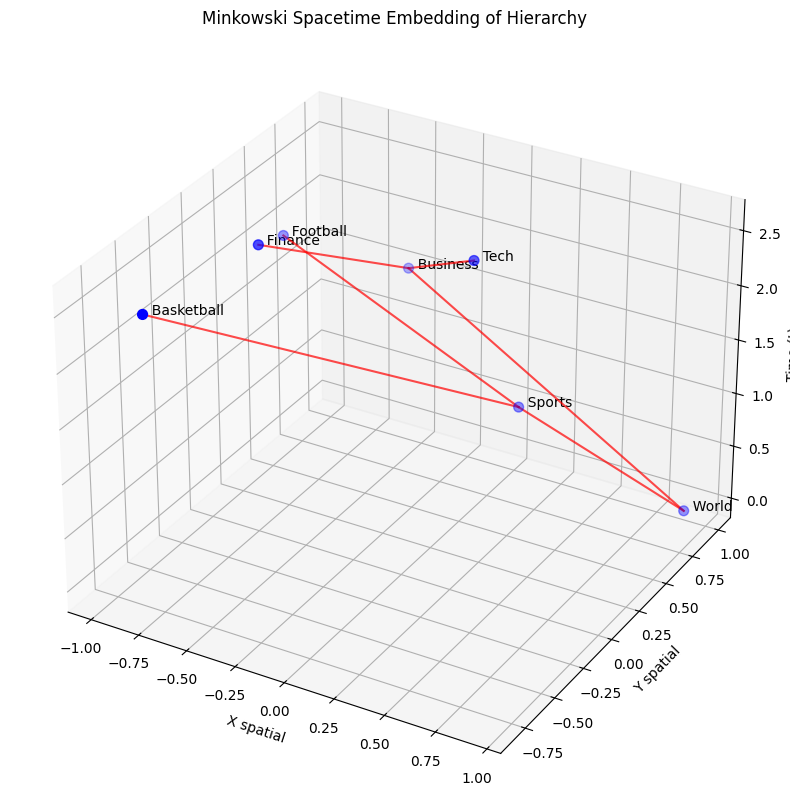

In [ ]:
# --- Visualization ---
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# Plot nodes
ax.scatter(coords[:, 0], coords[:, 1], coords[:, -1], c='blue', s=50)
for i, name in id_to_node.items():
    ax.text(coords[i, 0], coords[i, 1], coords[i, -1], f"  {name}", size=10, zorder=1, color='k')

# Plot hierarchical links (causal connections)
for child_id, parent_id in adj.items():
    p1 = coords[parent_id]
    p2 = coords[child_id]
    ax.plot([p1[0], p2[0]], [p1[1], p2[1]], [p1[-1], p2[-1]], c='red', alpha=0.7, linestyle='-')

    # Optional: Plot a simplified past light cone for parents
    # For simplicity, just draw a cone outline. True light cones are 4D projections.
    # cone_radius_at_child = p2[-1] - p1[-1] # dt
    # if cone_radius_at_child > 0:
    #     theta = np.linspace(0, 2 * np.pi, 100)
    #     # Cone from parent extending towards child's time slice
    #     x_cone_parent = p1[0] + cone_radius_at_child * np.cos(theta) * 0.5 # Scale for viz
    #     y_cone_parent = p1[1] + cone_radius_at_child * np.sin(theta) * 0.5 # Scale for viz
    #     ax.plot(x_cone_parent, y_cone_parent, p1[-1] + cone_radius_at_child, color='gray', alpha=0.2)


ax.set_xlabel("X spatial")
ax.set_ylabel("Y spatial")
ax.set_zlabel("Time (t)")
ax.set_title("Minkowski Spacetime Embedding of Hierarchy")
plt.show()

In [ ]:
def get_ancestors_causally(node_id, current_coords, all_node_ids):
    """
    Finds the causal ancestor of a node.
    The paper's method: "select as its ancestor the one connected by
    a geodesic with the smallest proper time - that is, the minimal value of -Δs²"
    This means finding parent_id such that:
    1. parent_id is in the past light cone of node_id
    2. -minkowski_interval_sq(coords[node_id], coords[parent_id]) is minimized
       (or minkowski_interval_sq is maximized, since it's negative for timelike)
    """
    node_coord = current_coords[node_id]
    potential_parents = []

    for p_id in all_node_ids:
        if p_id == node_id:
            continue

        parent_coord = current_coords[p_id]
        if is_causally_connected(node_coord, parent_coord, strict=True): # node is child of p_id
            # Calculate proper time squared (which is -interval_sq for timelike)
            # interval_sq = -dt^2 + d_spatial^2. We want to MINIMIZE -interval_sq.
            # So, we want to MINIMIZE dt^2 - d_spatial^2.
            dt = node_coord[-1] - parent_coord[-1]
            d_spatial_sq_val = spatial_distance_sq(node_coord, parent_coord)
            proper_time_sq_val = dt**2 - d_spatial_sq_val # This is -Δs²

            potential_parents.append((p_id, proper_time_sq_val))

    if not potential_parents:
        return None

    # Sort by smallest proper time (largest -Δs²)
    potential_parents.sort(key=lambda x: x[1], reverse=True) # Maximize Δs² for largest proper time
                                                           # Smallest -Δs² means largest proper time.
                                                           # The paper says minimal value of -Δs²
                                                           # So we want the one with the *smallest* positive proper_time_sq_val
    potential_parents.sort(key=lambda x: x[1])


    # For this demo, we'll just check against the ground truth defined in `adj`
    # to simplify, but in a real scenario you'd pick the best one.
    # The paper's method is more robust.
    if potential_parents:
      return potential_parents[0][0] # Return ID of best causal ancestor
    return None


print("\nRetrieving hierarchy via causality:")
for_node_name = "Football"
start_node_id = node_to_id[for_node_name]
current_node_id = start_node_id
path = [id_to_node[current_node_id]]

all_ids = list(range(num_nodes))

print(f"Finding hierarchy for {id_to_node[start_node_id]}:")
while current_node_id is not None and current_node_id != root_id: # Stop at root or if no parent found
    print(f" Current node: {id_to_node[current_node_id]}")
    # Check against ground truth parent
    true_parent_id = adj.get(current_node_id)
    if true_parent_id is None:
        print(f"  {id_to_node[current_node_id]} is root or has no defined parent.")
        break

    # Find causal ancestor using the paper's principle (simplified)
    causal_ancestor_id = get_ancestors_causally(current_node_id, coords, all_ids)

    if causal_ancestor_id is not None:
        print(f"  Causal ancestor found: {id_to_node[causal_ancestor_id]}")
        print(f"  Ground truth parent: {id_to_node[true_parent_id]}")
        if causal_ancestor_id == true_parent_id:
            print("  Matches ground truth!")
        else:
            print("  MISMATCH with ground truth parent!")
            # This is where the paper's more sophisticated embedding and tie-breaking rules would be crucial
            # For a robust demo, the embedding needs to be very precise.
        path.append(id_to_node[causal_ancestor_id])
        current_node_id = causal_ancestor_id # Continue traversal
        if id_to_node[current_node_id] == "World": break # Stop at root
    else:
        print(f"  No causal ancestor found for {id_to_node[current_node_id]}.")
        break
    if len(path) > num_nodes : break # Safety break

print(f"Causally retrieved path for {for_node_name}: {' -> '.join(reversed(path))}")


Retrieving hierarchy via causality:
Finding hierarchy for Football:
 Current node: Football
  Causal ancestor found: Sports
  Ground truth parent: Sports
  Matches ground truth!
 Current node: Sports
  Causal ancestor found: World
  Ground truth parent: World
  Matches ground truth!
Causally retrieved path for Football: World -> Sports -> Football


Loading dataset...
Loaded 2257 documents.
Extracting TF features...
TF matrix shape: (2257, 18191)
Training LDA model with 10 topics...
LDA model trained.
Topic-word distributions shape: (10, 18191)

Top words per LDA topic:
Topic 0:
com edu msg islam organization
Topic 1:
maria jcj albany muenchen tellabs
Topic 2:
navy mil virtual reality color
Topic 3:
graphics ___ __ jim comp
Topic 4:
dyer msg spdcc steve com
Topic 5:
edu god organization people don
Topic 6:
edu com organization article cs
Topic 7:
points au edu monash sphere
Topic 8:
netcom noring jon sloan 408
Topic 9:
edu keith writes com caltech

Calculating pairwise topic distances (Jensen-Shannon)...
Topic distance matrix calculated.
Performing agglomerative clustering on topics...
Clustering complete.

Plotting dendrogram of topic hierarchy...


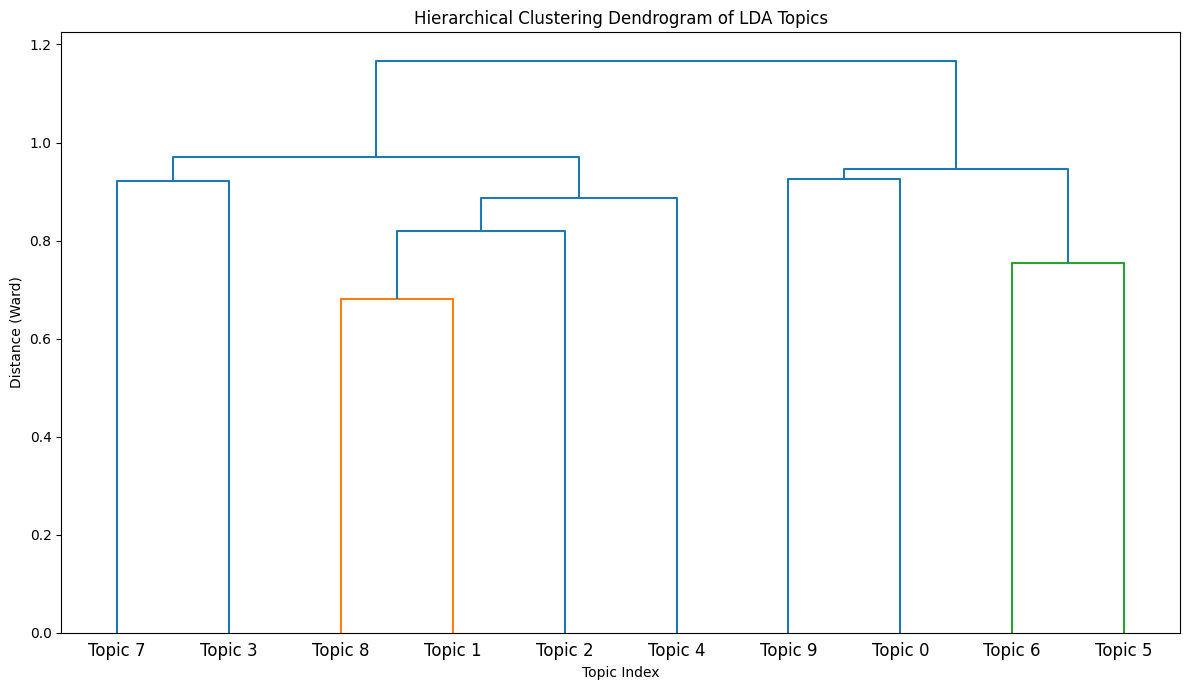


Extracting (child, parent) pairs from dendrogram...
Generated 19 hierarchical pairs.


In [ ]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.datasets import fetch_20newsgroups # Or use AG_NEWS if you have it readily available
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.spatial.distance import jensenshannon
import matplotlib.pyplot as plt

# --- 1. Load and Prepare Data (e.g., AG_NEWS or 20 Newsgroups) ---
# For simplicity, let's use a subset of 20 Newsgroups
categories = ['alt.atheism', 'soc.religion.christian', 'comp.graphics', 'sci.med']
print("Loading dataset...")
newsgroups_train = fetch_20newsgroups(subset='train', categories=categories, shuffle=True, random_state=42)
data_samples = newsgroups_train.data
print(f"Loaded {len(data_samples)} documents.")

# --- 2. Feature Extraction (TF for LDA) ---
print("Extracting TF features...")
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
tf = tf_vectorizer.fit_transform(data_samples)
feature_names = tf_vectorizer.get_feature_names_out()
print(f"TF matrix shape: {tf.shape}")

# --- 3. Train Standard LDA Model ---
n_topics = 10 # Number of initial flat topics
print(f"Training LDA model with {n_topics} topics...")
lda = LatentDirichletAllocation(n_components=n_topics, max_iter=10,
                                learning_method='online',
                                learning_offset=50.,
                                random_state=0)
lda.fit(tf)
print("LDA model trained.")

# --- 4. Get Topic-Word Distributions ---
# lda.components_ is [n_topics, n_features] with raw counts
# We need to normalize to get probabilities
topic_word_distributions = lda.components_ / lda.components_.sum(axis=1)[:, np.newaxis]
print(f"Topic-word distributions shape: {topic_word_distributions.shape}")

def display_topics(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic {topic_idx}:")
        print(" ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))

print("\nTop words per LDA topic:")
display_topics(lda, feature_names, 5)

# --- 5. Cluster Topics to Form a Hierarchy ---
# Calculate pairwise distance between topics (using Jensen-Shannon divergence on word distributions)
print("\nCalculating pairwise topic distances (Jensen-Shannon)...")
n_topics = topic_word_distributions.shape[0]
topic_distance_matrix = np.zeros((n_topics, n_topics))

for i in range(n_topics):
    for j in range(i + 1, n_topics):
        # Jensen-Shannon requires probability distributions (sum to 1)
        js_div = jensenshannon(topic_word_distributions[i, :], topic_word_distributions[j, :])
        topic_distance_matrix[i, j] = js_div
        topic_distance_matrix[j, i] = js_div # Symmetrize

print("Topic distance matrix calculated.")

# Perform Agglomerative Clustering on topics
# 'ward' method minimizes variance within clusters
print("Performing agglomerative clustering on topics...")
# The linkage matrix Z contains the hierarchical clustering information
# Each row in Z represents a merge of two clusters.
# Z[i, 0] and Z[i, 1] are the indices of the clusters being merged.
# Z[i, 2] is the distance between these two clusters.
# Z[i, 3] is the number of original observations in the newly formed cluster.
linked_topics = linkage(topic_distance_matrix, method='ward')
print("Clustering complete.")

# --- 6. Visualize the Topic Hierarchy (Dendrogram) ---
print("\nPlotting dendrogram of topic hierarchy...")
plt.figure(figsize=(12, 7))
topic_labels = [f"Topic {i}" for i in range(n_topics)]
dendrogram(linked_topics,
            orientation='top',
            labels=topic_labels,
            distance_sort='descending',
            show_leaf_counts=True)
plt.title('Hierarchical Clustering Dendrogram of LDA Topics')
plt.xlabel('Topic Index')
plt.ylabel('Distance (Ward)')
plt.tight_layout()
plt.show()

# --- 7. "Assume" the Hierarchy for Embedding (Conceptual Next Step) ---
# The `linked_topics` matrix IS the hierarchy.
# To use it for Minkowski embedding as (child, parent) pairs:
# - Each original LDA topic is a leaf node in this new hierarchy.
# - Each merge operation in `linked_topics` creates a new internal (parent) node.
#   The children are the two clusters/topics that were merged.
# You'd need to assign IDs to these new internal nodes.
# For example, if topic_i and topic_j merge to form new_node_k,
# then (topic_i, new_node_k) and (topic_j, new_node_k) are parent-child pairs.
# This process can be recursively applied up the dendrogram to extract all (child, parent) pairs.

def extract_hierarchy_from_linkage(linkage_matrix, leaf_labels):
    """
    Extracts (child_label, parent_label) pairs from a scipy linkage matrix.
    Internal nodes are given new labels.
    """
    n_leaves = len(leaf_labels)
    n_internal_nodes = linkage_matrix.shape[0]
    node_labels = list(leaf_labels) # Start with leaf labels

    # Assign labels to internal nodes
    for i in range(n_internal_nodes):
        node_labels.append(f"InternalNode_{i}")

    hierarchy_pairs = []
    for i in range(n_internal_nodes):
        cluster_idx1 = int(linkage_matrix[i, 0])
        cluster_idx2 = int(linkage_matrix[i, 1])
        parent_node_label = node_labels[n_leaves + i] # Label of the newly formed cluster

        child1_label = node_labels[cluster_idx1]
        child2_label = node_labels[cluster_idx2]

        hierarchy_pairs.append((child1_label, parent_node_label))
        hierarchy_pairs.append((child2_label, parent_node_label))

    # Find the ultimate root (the last parent node created)
    if n_internal_nodes > 0:
         root_label = node_labels[n_leaves + n_internal_nodes - 1]
         hierarchy_pairs.append((root_label, None)) # Root has no parent
    elif n_leaves == 1: # Single topic case
        hierarchy_pairs.append((node_labels[0], None))


    return hierarchy_pairs

print("\nExtracting (child, parent) pairs from dendrogram...")
assumed_topic_hierarchy_pairs = extract_hierarchy_from_linkage(linked_topics, topic_labels)
print(f"Generated {len(assumed_topic_hierarchy_pairs)} hierarchical pairs.")
# for child, parent in assumed_topic_hierarchy_pairs:
#     print(f"{child} -> {parent}")

# Now `assumed_topic_hierarchy_pairs` can be used as input to the
# Minkowski spacetime embedding code from the previous example.
# Each document could then be represented by the (x,y,t) coordinates of its dominant
# LDA topic (which is now a leaf in this new hierarchy), or a weighted average
# of the coordinates of its topic distribution.


--- Starting Minkowski Embedding for LDA Topic Hierarchy ---
LDA Hierarchy Nodes (19): ['InternalNode_0', 'InternalNode_1', 'InternalNode_2', 'InternalNode_3', 'InternalNode_4'] ...
LDA Hierarchy Root ID: 8 (InternalNode_8)

Starting embedding adjustment for LDA hierarchy...
Iteration 0: Violations = 18, Total Delta Sum = 9.6564
Iteration 200: Violations = 18, Total Delta Sum = 0.0000
Iteration 400: Violations = 18, Total Delta Sum = 0.0000
Iteration 600: Violations = 18, Total Delta Sum = 0.0000
Iteration 800: Violations = 18, Total Delta Sum = 0.0000
Iteration 1000: Violations = 18, Total Delta Sum = 0.0000
Iteration 1200: Violations = 18, Total Delta Sum = 0.0000
Iteration 1400: Violations = 18, Total Delta Sum = 0.0000
Iteration 1600: Violations = 18, Total Delta Sum = 0.0000
Iteration 1800: Violations = 18, Total Delta Sum = 0.0000
Iteration 2000: Violations = 18, Total Delta Sum = 0.0000
Iteration 2200: Violations = 18, Total Delta Sum = 0.0000
Iteration 2400: Violations = 18, T

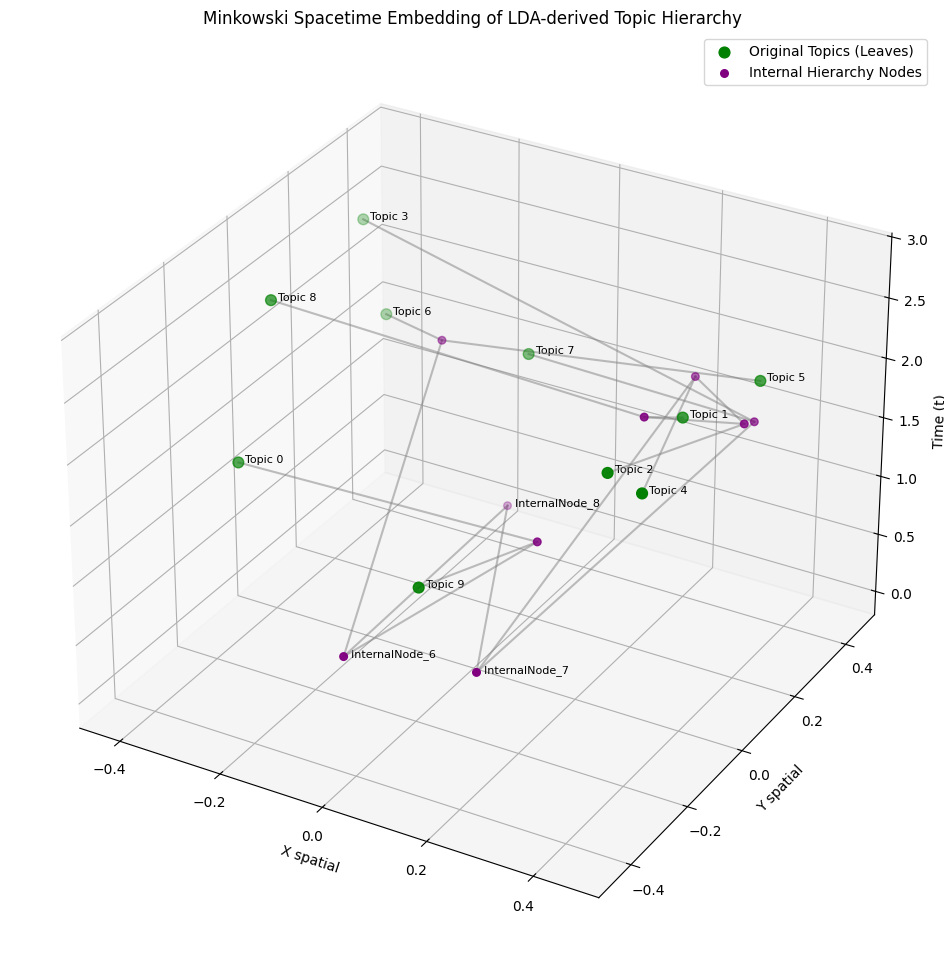


Testing hierarchy traversal (simplified - checking direct ground truth parent retrieval):
Starting traversal from leaf: Topic 0
  Node: Topic 0
    Ground Truth Parent: InternalNode_5
    Causally Retrieved Ancestor: InternalNode_5
      Match!
  Node: InternalNode_5
    Ground Truth Parent: InternalNode_6
    Causally Retrieved Ancestor: InternalNode_6
      Match!
  Node: InternalNode_6
    Ground Truth Parent: InternalNode_8
    Causally Retrieved Ancestor: InternalNode_8
      Match!
  Reached root: InternalNode_8

Path for Topic 0: InternalNode_8 -> InternalNode_6 -> InternalNode_5 -> Topic 0


In [ ]:
# Ensure the previous LDA + Clustering code has been run, and these are available:
# - assumed_topic_hierarchy_pairs: List of (child_label, parent_label)
# - topic_labels: List of original LDA topic labels (e.g., "Topic 0", "Topic 1", ...)

# Also, make sure you have the Minkowski embedding functions from before:
# - minkowski_interval_sq(coord1, coord2)
# - spatial_distance_sq(coord1, coord2)
# - is_causally_connected(child_coord, parent_coord, strict=True)
# - get_ancestors_causally(node_id, current_coords, all_node_ids) # (We might simplify this for the demo)

# --- Part 1: Setup for Minkowski Embedding with LDA Hierarchy ---

print("\n--- Starting Minkowski Embedding for LDA Topic Hierarchy ---")

# Use the hierarchy derived from LDA
hierarchy_pairs_for_embedding = assumed_topic_hierarchy_pairs # This comes from the LDA part

# Extract unique nodes and create a mapping for the new hierarchy
all_node_names_from_lda_hierarchy = set()
root_node_name_from_lda = None
for child, parent in hierarchy_pairs_for_embedding:
    all_node_names_from_lda_hierarchy.add(child)
    if parent is not None:
        all_node_names_from_lda_hierarchy.add(parent)
    else: # This is the root
        root_node_name_from_lda = child # The child here is the root node

# If the root was implicitly defined (e.g. last internal node) and not in the set, add it.
# The extract_hierarchy_from_linkage should add (root, None)
if root_node_name_from_lda is None and hierarchy_pairs_for_embedding:
    # Find the node that is a parent but never a child (if multiple, pick one, or the last one from linkage)
    potential_roots = set(p for c,p in hierarchy_pairs_for_embedding if p is not None) - \
                      set(c for c,p in hierarchy_pairs_for_embedding)
    if potential_roots:
        root_node_name_from_lda = list(potential_roots)[0] # Or a more specific choice
        if root_node_name_from_lda not in all_node_names_from_lda_hierarchy: # Should be there if it's a parent
             all_node_names_from_lda_hierarchy.add(root_node_name_from_lda)
        print(f"Identified root: {root_node_name_from_lda}")
    else:
        # This might happen if there's only one node (one topic)
        if len(all_node_names_from_lda_hierarchy) == 1:
            root_node_name_from_lda = list(all_node_names_from_lda_hierarchy)[0]
            # Add the (root, None) pair if it wasn't created by extract_hierarchy_from_linkage
            if not any(p is None for c,p in hierarchy_pairs_for_embedding):
                 hierarchy_pairs_for_embedding.append((root_node_name_from_lda, None))

        else:
            print("Error: Could not determine root for LDA hierarchy unambiguously.")
            # Handle error or make an assumption


nodes_lda_h = sorted(list(all_node_names_from_lda_hierarchy))
node_to_id_lda_h = {name: i for i, name in enumerate(nodes_lda_h)}
id_to_node_lda_h = {i: name for i, name in enumerate(nodes_lda_h)}
num_nodes_lda_h = len(nodes_lda_h)

print(f"LDA Hierarchy Nodes ({num_nodes_lda_h}): {nodes_lda_h[:5]} ...") # Print a few
# print(f"LDA Hierarchy Node to ID: {node_to_id_lda_h}")

# Represent hierarchy as child_id -> parent_id
adj_lda_h = {}
if hierarchy_pairs_for_embedding: # Ensure it's not empty
    for child, parent in hierarchy_pairs_for_embedding:
        if parent is not None: # Don't add edges from root to None
            if child in node_to_id_lda_h and parent in node_to_id_lda_h:
                 adj_lda_h[node_to_id_lda_h[child]] = node_to_id_lda_h[parent]
            else:
                print(f"Warning: Node missing from mapping: child='{child}', parent='{parent}'")


if root_node_name_from_lda and root_node_name_from_lda in node_to_id_lda_h:
    root_id_lda_h = node_to_id_lda_h[root_node_name_from_lda]
    print(f"LDA Hierarchy Root ID: {root_id_lda_h} ({id_to_node_lda_h[root_id_lda_h]})")
else:
    print("Warning: Root ID for LDA hierarchy not properly set.")
    root_id_lda_h = None # Or handle error


# print(f"LDA Hierarchy Adjacency (child_id -> parent_id): {adj_lda_h}")

# --- Part 2: Minkowski Spacetime Embedding (Using previous simplified iterative adjustment) ---
# Re-initialize coordinates for this new set of nodes
coords_lda_h = np.random.rand(num_nodes_lda_h, NUM_SPATIAL_DIMS + 1) * 2 - 1
coords_lda_h[:, :-1] = np.random.uniform(-0.5, 0.5, size=(num_nodes_lda_h, NUM_SPATIAL_DIMS)) # Smaller spatial spread
coords_lda_h[:, -1] = 0.0 # Initialize all times to 0

MAX_ITERATIONS_LDA = 3000 # May need more for larger hierarchies
LEARNING_RATE_FACTOR_LDA = 0.1
# EPSILON_1 and EPSILON_2 are defined from before

print("\nStarting embedding adjustment for LDA hierarchy...")
for iteration in range(MAX_ITERATIONS_LDA):
    violations = 0
    total_delta_sum = 0

    for child_id, parent_id in adj_lda_h.items():
        child_coord = coords_lda_h[child_id]
        parent_coord = coords_lda_h[parent_id]

        t_child = child_coord[-1]
        t_parent = parent_coord[-1]

        d_xy_spatial = np.sqrt(spatial_distance_sq(child_coord, parent_coord))
        t_xy_current = t_child - t_parent
        t_min_required = d_xy_spatial + EPSILON_1

        if t_xy_current < t_min_required:
            violations += 1
            delta_t = t_min_required - t_xy_current
            total_delta_sum += delta_t

            coords_lda_h[child_id, -1] += delta_t * (1 - EPSILON_2) * LEARNING_RATE_FACTOR_LDA
            if EPSILON_2 > 0:
                 coords_lda_h[parent_id, -1] -= delta_t * EPSILON_2 * LEARNING_RATE_FACTOR_LDA

    if iteration % 200 == 0:
        print(f"Iteration {iteration}: Violations = {violations}, Total Delta Sum = {total_delta_sum:.4f}")

    if violations == 0 and total_delta_sum < 1e-5:
        print(f"Converged at iteration {iteration}!")
        break
else:
    print("Max iterations reached for LDA hierarchy. May not have fully converged.")

# Post-processing: ensure root node is at t=0 or earliest
if root_id_lda_h is not None:
    # Shift all times so that the root node's time is 0 (or close to it)
    # Find min time and shift all coordinates by that amount.
    # More robust: Ensure children are always later than parents by some margin.
    min_time_val = np.min(coords_lda_h[:, -1])
    coords_lda_h[:, -1] -= min_time_val
else:
    print("Skipping time shift as root_id_lda_h is None")


print("\nFinal Coordinates for LDA Hierarchy (x, y, t):")
for i in range(min(5, num_nodes_lda_h)): # Print first 5
    print(f"{id_to_node_lda_h[i]}: {coords_lda_h[i]}")

print("\nVerifying causal connections for LDA Hierarchy (sample):")
sample_verified = 0
for child_id, parent_id in adj_lda_h.items():
    if sample_verified >= 5: break # Print a few
    child_name = id_to_node_lda_h[child_id]
    parent_name = id_to_node_lda_h[parent_id]
    connected = is_causally_connected(coords_lda_h[child_id], coords_lda_h[parent_id])
    dt = coords_lda_h[child_id, -1] - coords_lda_h[parent_id, -1]
    d_spatial = np.sqrt(spatial_distance_sq(coords_lda_h[child_id], coords_lda_h[parent_id]))
    print(f"{child_name} -> {parent_name}: Causally OK = {connected} (dt={dt:.3f}, d_sp={d_spatial:.3f}, dt_req={d_spatial+EPSILON_1:.3f})")
    sample_verified +=1

# --- Part 3: Visualization of LDA Hierarchy Embedding ---
fig_lda = plt.figure(figsize=(15, 12))
ax_lda = fig_lda.add_subplot(111, projection='3d')

# Plot nodes
# Separate leaf (original topics) and internal nodes for different coloring/sizing
leaf_node_ids_lda = [node_to_id_lda_h[name] for name in topic_labels if name in node_to_id_lda_h]
internal_node_ids_lda = [i for i in range(num_nodes_lda_h) if i not in leaf_node_ids_lda]

if leaf_node_ids_lda:
    ax_lda.scatter(coords_lda_h[leaf_node_ids_lda, 0], coords_lda_h[leaf_node_ids_lda, 1], coords_lda_h[leaf_node_ids_lda, -1],
                   c='green', s=60, label='Original Topics (Leaves)')
if internal_node_ids_lda:
    ax_lda.scatter(coords_lda_h[internal_node_ids_lda, 0], coords_lda_h[internal_node_ids_lda, 1], coords_lda_h[internal_node_ids_lda, -1],
                   c='purple', s=30, label='Internal Hierarchy Nodes')

for i in range(num_nodes_lda_h):
    # Only label a subset to avoid clutter, e.g., original topics or high-level internal nodes
    if id_to_node_lda_h[i] in topic_labels or "InternalNode" not in id_to_node_lda_h[i] or \
       coords_lda_h[i, -1] < 1.0 : # Example: label nodes with earlier times (closer to root)
        ax_lda.text(coords_lda_h[i, 0], coords_lda_h[i, 1], coords_lda_h[i, -1],
                    f"  {id_to_node_lda_h[i]}", size=8, zorder=1, color='k')


# Plot hierarchical links
for child_id, parent_id in adj_lda_h.items():
    p1 = coords_lda_h[parent_id]
    p2 = coords_lda_h[child_id]
    ax_lda.plot([p1[0], p2[0]], [p1[1], p2[1]], [p1[-1], p2[-1]], c='gray', alpha=0.5, linestyle='-')

ax_lda.set_xlabel("X spatial")
ax_lda.set_ylabel("Y spatial")
ax_lda.set_zlabel("Time (t)")
ax_lda.set_title("Minkowski Spacetime Embedding of LDA-derived Topic Hierarchy")
ax_lda.legend()
plt.show()

# --- Part 4: Testing Hierarchy Retrieval (Simplified for this demo) ---
# The `get_ancestors_causally` function might be too slow or unstable for a
# poorly converged/large hierarchy without the paper's precise method.
# For a demo, we can just visually inspect or check a few known paths.

print("\nTesting hierarchy traversal (simplified - checking direct ground truth parent retrieval):")
# Pick a leaf node (an original LDA topic)
if leaf_node_ids_lda:
    test_leaf_node_id = leaf_node_ids_lda[0] # Example: first original topic
    test_leaf_node_name = id_to_node_lda_h[test_leaf_node_id]
    print(f"Starting traversal from leaf: {test_leaf_node_name}")

    current_node_id_test = test_leaf_node_id
    path_retrieved_lda = [id_to_node_lda_h[current_node_id_test]]

    all_ids_lda = list(range(num_nodes_lda_h))

    for _ in range(num_nodes_lda_h): # Max depth
        true_parent_id_test = adj_lda_h.get(current_node_id_test)

        # Using the more complex causal ancestor finder
        # This is the real test of the embedding's geometric properties
        causal_ancestor_id_test = get_ancestors_causally(current_node_id_test, coords_lda_h, all_ids_lda)

        print(f"  Node: {id_to_node_lda_h[current_node_id_test]}")
        if true_parent_id_test is not None:
            print(f"    Ground Truth Parent: {id_to_node_lda_h[true_parent_id_test]}")
        else:
            print(f"    Ground Truth Parent: None (is root or error)")

        if causal_ancestor_id_test is not None:
            print(f"    Causally Retrieved Ancestor: {id_to_node_lda_h[causal_ancestor_id_test]}")
            if true_parent_id_test is not None and causal_ancestor_id_test == true_parent_id_test:
                print("      Match!")
            elif true_parent_id_test is not None:
                 print("      MISMATCH!")
            path_retrieved_lda.append(id_to_node_lda_h[causal_ancestor_id_test])
            current_node_id_test = causal_ancestor_id_test
            if current_node_id_test == root_id_lda_h:
                print(f"  Reached root: {id_to_node_lda_h[root_id_lda_h]}")
                break
        else:
            print("    No causal ancestor found by retrieval method.")
            if true_parent_id_test is None:
                print("      Correctly no parent (reached root by ground truth).")
            break

    print(f"\nPath for {test_leaf_node_name}: {' -> '.join(reversed(path_retrieved_lda))}")
else:
    print("No leaf nodes found in LDA hierarchy to test traversal.")

Initial vector V: [1.41421356 1.         0.         0.        ]
V . V (norm squared): -1.0000
Type of V: Future-pointing Timelike

Lorentz Boost Matrix (beta=0.5):
[[ 1.15470054 -0.57735027  0.          0.        ]
 [-0.57735027  1.15470054  0.          0.        ]
 [ 0.          0.          1.          0.        ]
 [ 0.          0.          0.          1.        ]]

Spatial Z-Rotation Matrix (theta=0.79 rad):
[[ 1.          0.          0.          0.        ]
 [ 0.          0.70710678 -0.70710678  0.        ]
 [ 0.          0.70710678  0.70710678  0.        ]
 [ 0.          0.          0.          1.        ]]

Boosted V': [1.05564289 0.33820396 0.         0.        ]
V' . V' (norm squared): -1.0000 (should be same as V.V)
Type of V': Future-pointing Timelike

Rotated V'': [1.41421356 0.70710678 0.70710678 0.        ]
V'' . V'' (norm squared): -1.0000 (should be same as V.V)
Type of V'': Future-pointing Timelike

Boosted then Rotated V''': [1.05564289 0.23914631 0.23914631 0.        ]

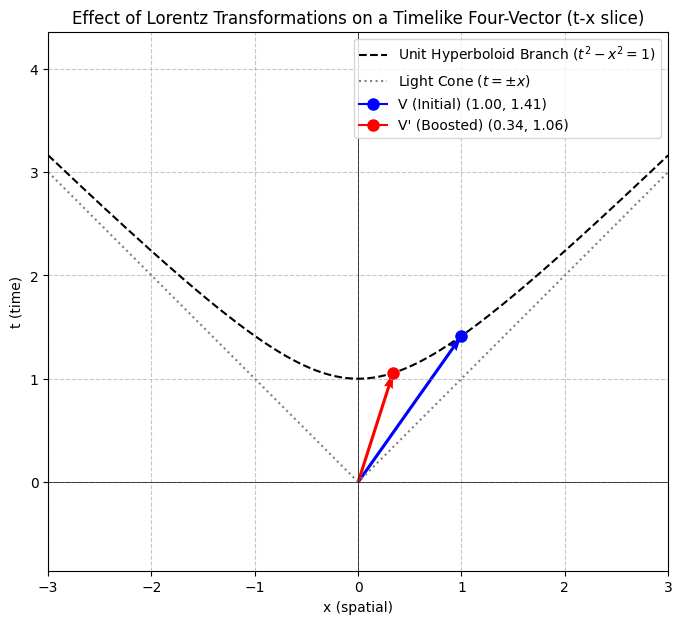


--- Semantic Interpretation ---
Imagine V_initial represents the core meaning of 'Fast Car'.
 - It's timelike and future-pointing: implies progression, existence through time.
 - Its components (t,x,y,z) give its 'orientation' in semantic spacetime.
 - The norm V.V = -1 could be a 'unit of semantic intensity'.

Applying a Lorentz Boost (V_boosted):
 - This changes the 'perceived velocity' or 'energy-momentum' of the concept.
 - If V_initial was 'Car at rest (semantically)', boosting it could mean 'Car moving fast'.
   V_initial t=1.41, x=1.00
   V_boosted t=1.06, x=0.34 (t and x components changed).
 - Semantically, this could shift 'Fast Car' to 'Extremely Fast Car' or emphasize its 'motion' aspect.

Applying a Spatial Rotation (V_rotated):
 - If our initial vector had non-zero y or z components, rotation would change its spatial aspect.
   V_initial (t,x,y,z): [1.41421356 1.         0.         0.        ]
   V_rotated (t,x,y,z): [1.41421356 0.70710678 0.70710678 0.        ]
 - Seman

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D # For potential 3D visualization later

# --- Configuration ---
# Ensure NUM_SPATIAL_DIMS is 3 for (t, x, y, z) four-vectors
# Let's use the (t, x, y, z) ordering for four-vectors. Metric signature (-+++) or (+---)
# We'll use -dt^2 + dx^2 + dy^2 + dz^2 for V.V, so t is the first component v[0].
# This means the metric tensor diag(-1, 1, 1, 1)

# --- Helper Functions ---
def minkowski_norm_sq(v):
    """Calculates v . v = -v_t^2 + v_x^2 + v_y^2 + v_z^2"""
    if len(v) != 4:
        raise ValueError("Four-vector must have 4 components (t, x, y, z)")
    return -v[0]**2 + v[1]**2 + v[2]**2 + v[3]**2

def get_vector_type(v):
    norm_sq = minkowski_norm_sq(v)
    if np.isclose(norm_sq, 0):
        return "Lightlike"
    elif norm_sq < 0:
        if v[0] > 0:
            return "Future-pointing Timelike"
        elif v[0] < 0:
            return "Past-pointing Timelike"
        else:
            return "Timelike (t=0, should not happen for physical particles)"
    else:
        return "Spacelike"

# --- Lorentz Transformation Matrices ---

def lorentz_boost_x(beta):
    """Returns Lorentz transformation matrix for a boost along the x-axis.
    beta = v/c. Rapidity phi = arctanh(beta).
    gamma = 1 / sqrt(1 - beta^2)
    """
    if abs(beta) >= 1:
        raise ValueError("Beta must be between -1 and 1 (exclusive for massive particles)")
    gamma = 1.0 / np.sqrt(1.0 - beta**2)
    return np.array([
        [gamma,     -gamma * beta, 0,       0      ],
        [-gamma * beta, gamma,         0,       0      ],
        [0,         0,             1,       0      ],
        [0,         0,             0,       1      ]
    ])

def spatial_rotation_z(theta_rad):
    """Returns transformation matrix for a spatial rotation around the z-axis."""
    c = np.cos(theta_rad)
    s = np.sin(theta_rad)
    return np.array([
        [1,  0,  0,  0],
        [0,  c, -s,  0],
        [0,  s,  c,  0],
        [0,  0,  0,  1]
    ])

def spatial_rotation_y(theta_rad):
    """Returns transformation matrix for a spatial rotation around the y-axis."""
    c = np.cos(theta_rad)
    s = np.sin(theta_rad)
    return np.array([
        [1,  0,  0,  0],
        [0,  c,  0,  s],
        [0,  0,  1,  0],
        [0, -s,  0,  c]
    ])


# --- Demo Starts Here ---

# 1. Define an initial future-pointing timelike four-vector
# Let's make it a unit timelike vector, so v.v = -1
# Example: (t, x, y, z)
v_initial = np.array([np.sqrt(2), 1.0, 0.0, 0.0]) # t=sqrt(2), x=1. So -2 + 1 = -1.
# v_initial = np.array([5.0, 3.0, 0.0, 0.0]) # Another example, t=5, x=3 => -25 + 9 = -16

print(f"Initial vector V: {v_initial}")
print(f"V . V (norm squared): {minkowski_norm_sq(v_initial):.4f}")
print(f"Type of V: {get_vector_type(v_initial)}")

# 2. Define some transformations
# Boost along x-axis with beta = 0.5 (velocity = 0.5c)
beta_boost = 0.5
L_boost_x = lorentz_boost_x(beta_boost)
print(f"\nLorentz Boost Matrix (beta={beta_boost}):\n{L_boost_x}")

# Spatial rotation around z-axis by 45 degrees (pi/4 radians)
theta_rot_z = np.pi / 4
L_rot_z = spatial_rotation_z(theta_rot_z)
print(f"\nSpatial Z-Rotation Matrix (theta={theta_rot_z:.2f} rad):\n{L_rot_z}")

# 3. Apply transformations
v_boosted = L_boost_x @ v_initial
v_rotated = L_rot_z @ v_initial
v_boosted_then_rotated = L_rot_z @ v_boosted # Order matters!

print(f"\nBoosted V': {v_boosted}")
print(f"V' . V' (norm squared): {minkowski_norm_sq(v_boosted):.4f} (should be same as V.V)")
print(f"Type of V': {get_vector_type(v_boosted)}")

print(f"\nRotated V'': {v_rotated}")
print(f"V'' . V'' (norm squared): {minkowski_norm_sq(v_rotated):.4f} (should be same as V.V)")
print(f"Type of V'': {get_vector_type(v_rotated)}")

print(f"\nBoosted then Rotated V''': {v_boosted_then_rotated}")
print(f"V''' . V''' (norm squared): {minkowski_norm_sq(v_boosted_then_rotated):.4f} (should be same as V.V)")
print(f"Type of V''': {get_vector_type(v_boosted_then_rotated)}")


# --- 4. Visualization (2D slice: t-x plane, assuming y=z=0 for simplicity) ---
# This shows how vectors move on the hyperboloid -t^2 + x^2 = -C (where C = -V.V if y=z=0)

# Plot the unit hyperboloid branch for future-pointing timelike vectors: t^2 - x^2 = 1  => t = sqrt(1 + x^2)
# (More generally, t^2 - (x^2+y^2+z^2) = m^2, where -m^2 is the norm squared)
# For our v_initial where V.V = -1, we have m^2 = 1.
# If y=z=0, then t^2 - x^2 = 1.

x_hyperbola = np.linspace(-3, 3, 200)
t_hyperbola_future = np.sqrt(1 + x_hyperbola**2) # Only future sheet t > 0

plt.figure(figsize=(8, 7))
plt.plot(x_hyperbola, t_hyperbola_future, 'k--', label='Unit Hyperboloid Branch ($t^2 - x^2 = 1$)')
# plt.plot(x_hyperbola, -t_hyperbola_future, 'k--') # Past sheet

# Plot light cone lines t = x and t = -x
plt.plot(x_hyperbola, np.abs(x_hyperbola), 'gray', linestyle=':', label='Light Cone ($t = \pm x$)')


# Function to plot a 4-vector's (t,x) components if y,z are small enough
def plot_tx(vector, label, color, marker='o'):
    if np.isclose(vector[2], 0) and np.isclose(vector[3], 0): # Only plot if y and z are near zero
        plt.plot(vector[1], vector[0], marker=marker, markersize=8, color=color, label=f"{label} ({vector[1]:.2f}, {vector[0]:.2f})")
        plt.quiver(0, 0, vector[1], vector[0], angles='xy', scale_units='xy', scale=1, color=color, width=0.005)
    else:
        print(f"Cannot plot {label} in 2D t-x slice as y or z is non-zero: (y={vector[2]:.2f}, z={vector[3]:.2f})")


# Plot the vectors. Our initial vector is already in the t-x plane.
# The boosted vector (boost along x) will also be in the t-x plane.
# The rotated vector (rotation around z) will move out of the t-x plane if x or y was non-zero.
# The boosted_then_rotated will also likely be out of the t-x plane.

plot_tx(v_initial, "V (Initial)", "blue")
plot_tx(v_boosted, "V' (Boosted)", "red")

# For v_rotated and v_boosted_then_rotated, they might not be in the t-x plane if the rotation was effective
# Let's check and print a message.
print("\nNote on 2D plotting:")
if not (np.isclose(v_rotated[2], 0) and np.isclose(v_rotated[3], 0)):
    print("V_rotated is NOT in the t-x plane due to z-rotation, so it won't appear on the 2D hyperboloid slice correctly.")
else:
    plot_tx(v_rotated, "V'' (Rotated)", "green") # Will only plot if y,z are zero

if not (np.isclose(v_boosted_then_rotated[2], 0) and np.isclose(v_boosted_then_rotated[3], 0)):
    print("V_boosted_then_rotated is NOT in the t-x plane, so it won't appear on the 2D hyperboloid slice correctly.")
else:
    plot_tx(v_boosted_then_rotated, "V''' (Boosted then Rotated)", "orange")


plt.xlabel("x (spatial)")
plt.ylabel("t (time)")
plt.title("Effect of Lorentz Transformations on a Timelike Four-Vector (t-x slice)")
plt.axhline(0, color='black', linewidth=0.5)
plt.axvline(0, color='black', linewidth=0.5)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.axis('equal') # Important for visualizing the geometry correctly
plt.xlim([-3, 3])
plt.ylim([0, 3.5]) # Focus on future light cone
plt.show()

# --- Semantic Interpretation (Discussion) ---
print("\n--- Semantic Interpretation ---")
print("Imagine V_initial represents the core meaning of 'Fast Car'.")
print(" - It's timelike and future-pointing: implies progression, existence through time.")
print(" - Its components (t,x,y,z) give its 'orientation' in semantic spacetime.")
print(" - The norm V.V = -1 could be a 'unit of semantic intensity'.")

print("\nApplying a Lorentz Boost (V_boosted):")
print(" - This changes the 'perceived velocity' or 'energy-momentum' of the concept.")
print(" - If V_initial was 'Car at rest (semantically)', boosting it could mean 'Car moving fast'.")
print(f"   V_initial t={v_initial[0]:.2f}, x={v_initial[1]:.2f}")
print(f"   V_boosted t={v_boosted[0]:.2f}, x={v_boosted[1]:.2f} (t and x components changed).")
print(" - Semantically, this could shift 'Fast Car' to 'Extremely Fast Car' or emphasize its 'motion' aspect.")

print("\nApplying a Spatial Rotation (V_rotated):")
print(" - If our initial vector had non-zero y or z components, rotation would change its spatial aspect.")
print(f"   V_initial (t,x,y,z): {v_initial}")
print(f"   V_rotated (t,x,y,z): {v_rotated}")
print(" - Semantically, if 'direction' in (x,y,z) space encoded attributes (e.g., x=speed, y=color, z=size),")
print("   then a spatial rotation would change the emphasis on these attributes, e.g., from 'Fast Red Car' to 'Fast Blue Car' if the rotation was in the 'color plane'.")
print("   Our v_initial was (sqrt(2),1,0,0). Rotating around Z keeps t and z the same, but mixes x and y.")
print("   So, V_rotated has non-zero y. It's no longer purely in the t-x plane.")

print("\nKey takeaway:")
print("Lorentz transformations change the 'direction' (components) of a four-vector while PRESERVING its Minkowski norm (V.V) and thus its causal type (timelike, spacelike, null).")
print("This is analogous to rotations in Euclidean space preserving length while changing direction.")
print("If semantic meaning is encoded in these 'Minkowski directions', then Lorentz transformations are the natural way to modify that meaning while respecting the spacetime structure.")

1170 concepts, 1170 edges
epoch   0  violations 1070/1170
epoch  20  violations 948/1170
epoch  40  violations 813/1170
epoch  60  violations 731/1170
epoch  80  violations 679/1170
epoch 100  violations 634/1170
epoch 120  violations 594/1170
epoch 140  violations 562/1170
epoch 160  violations 543/1170
epoch 180  violations 520/1170
epoch 200  violations 495/1170
epoch 220  violations 471/1170
epoch 240  violations 457/1170
epoch 260  violations 444/1170
epoch 280  violations 433/1170


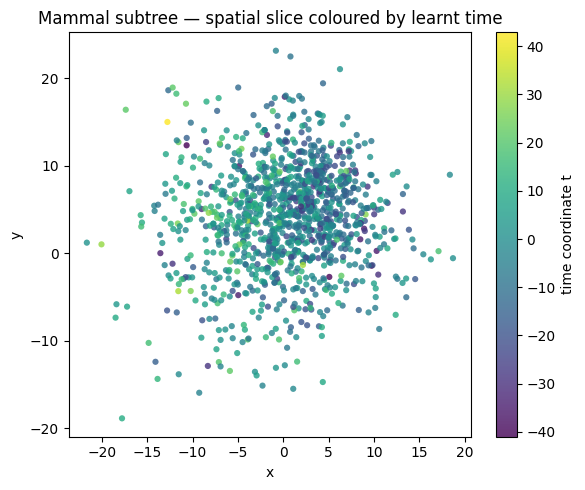

In [ ]:
# spacetime_demo.py
# ------------------------------------------------------------
# A minimal demo: mapping BERT embeddings to 3-D Minkowski
# space so that WordNet "is-a" edges become causal links.
# ------------------------------------------------------------
import random, math, itertools
import torch, torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

# ---------- 1.  WordNet subtree (mammals) ----------
import nltk, os, warnings
warnings.filterwarnings("ignore")
nltk.download("wordnet", quiet=True)
from nltk.corpus import wordnet as wn

root_syn = wn.synset("mammal.n.01")
subtree   = list(root_syn.closure(lambda s: s.hyponyms())) + [root_syn]
subtree   = [s for s in subtree if len(s.lemmas())]          # keep named ones

names = [s.lemmas()[0].name().replace("_"," ") for s in subtree]
idx   = {s:i for i,s in enumerate(subtree)}

# child-parent edges (WordNet stores parent->child)
edges = [(idx[ch], idx[p]) for p in subtree for ch in p.hyponyms()]
print(f"{len(names)} concepts, {len(edges)} edges")

# parent-depth for colouring
depth = [None]*len(names)
depth[idx[root_syn]] = 0
queue = [idx[root_syn]]
while queue:
    p = queue.pop(0)
    for ch_i, pa_i in edges:
        if pa_i==p and depth[ch_i] is None:
            depth[ch_i] = depth[p]+1
            queue.append(ch_i)
depth = np.array(depth)

# ---------- 2.  BERT embeddings ----------
from transformers import AutoModel, AutoTokenizer
tok  = AutoTokenizer.from_pretrained("bert-base-uncased")
bert = AutoModel.from_pretrained("bert-base-uncased").eval()
N = bert.config.hidden_size                      # 768

@torch.no_grad()
def embed(word: str) -> torch.Tensor:
    ids = tok(word, return_tensors="pt", truncation=True)
    h   = bert(**ids).last_hidden_state.mean(1)  # [1,N]
    return h.squeeze(0)

H = torch.stack([embed(w) for w in names])       # [V,N]

# ---------- 3.  Learn f:  (t,x,y,z) = (w_t·h ,  W_s h) ----------
device = "cuda" if torch.cuda.is_available() else "cpu"
H = H.to(device)

W_s = torch.randn(3, N, device=device, requires_grad=False)
w_t = torch.randn(1, N, device=device, requires_grad=True)

opt     = torch.optim.Adam([W_s, w_t], lr=3e-3)
margin  = 1e-3
BATCH   = 512
epochs  = 300

def batches(lst, n):
    for i in range(0, len(lst), n):
        yield lst[i:i+n]

for epoch in range(epochs):
    random.shuffle(edges)
    total, viol = 0,0
    for batch in batches(edges, BATCH):
        ch, pa = zip(*batch)
        h_c, h_p = H[list(ch)], H[list(pa)]
        Xc = F.linear(h_c, W_s)      # [B,3]
        Xp = F.linear(h_p, W_s)
        Tc = F.linear(h_c, w_t).squeeze(-1)
        Tp = F.linear(h_p, w_t).squeeze(-1)

        D  = (Xc - Xp).norm(dim=-1)
        Δt = Tc - Tp
        loss = F.relu(margin + D - Δt).mean()
        loss += 1e-4*(W_s.norm()+w_t.norm())

        opt.zero_grad();  loss.backward();  opt.step()

        viol += (Δt < D).sum().item()
        total += len(batch)

    if epoch%20==0:
        print(f"epoch {epoch:3d}  violations {viol}/{total}")

    if viol==0:
        print("✓ causal training complete"); break

# ---------- 4.  Visualise ----------
with torch.no_grad():
    xyz = F.linear(H, W_s).cpu().numpy()
    t   = F.linear(H, w_t).cpu().numpy().squeeze(-1)

plt.figure(figsize=(6,5))
sc = plt.scatter(xyz[:,0], xyz[:,1], c=t, cmap="viridis",
                 s=20, alpha=.8, edgecolors="none")
plt.colorbar(sc,label="time coordinate t")
plt.title("Mammal subtree — spatial slice coloured by learnt time")
plt.xlabel("x"); plt.ylabel("y"); plt.tight_layout()
plt.show()


In [ ]:
# -----------------------------------------------------------
#  EXTRA CONTEXT / ORTHOGONALITY REGULARISERS  –  new cell
# -----------------------------------------------------------
neg_coeff   = 1e-2      # weight for "spacelike negatives"
ortho_coeff = 1e-3      # weight for W_s row orthogonality
NEG_PER_POS = 2         # how many negatives per positive edge

# --- build a quick negative-pair table once ----------------
import numpy as np, collections
children_of = collections.defaultdict(set)
for ch,pa in edges: children_of[pa].add(ch)

# cousins = nodes sharing same parent but not linked directly
cousin_pairs = []
for sibs in children_of.values():
    sibs = list(sibs)
    cousin_pairs += list(itertools.combinations(sibs, 2))

rng = np.random.default_rng(0)
rand_neg = rng.choice(len(names), (len(edges)*NEG_PER_POS,2), replace=True)
neg_pairs = cousin_pairs + [(int(a),int(b)) for a,b in rand_neg]

print(f"{len(neg_pairs)} negative pairs (cousins + random)")

# --- re-open the optim loop for a few fine-tuning epochs ----
fine_epochs = 100
for epoch in range(fine_epochs):
    random.shuffle(edges)
    random.shuffle(neg_pairs)

    def chunk(lst,n):                 # simple helper
        for i in range(0,len(lst),n): yield lst[i:i+n]

    for pos,neg in zip(chunk(edges, BATCH),
                       chunk(neg_pairs, BATCH)):

        # ----- positive (causal) loss exactly as before -----
        ch, pa   = zip(*pos)
        h_c, h_p = H[list(ch)], H[list(pa)]
        Xc = F.linear(h_c, W_s);  Xp = F.linear(h_p, W_s)
        Tc = F.linear(h_c, w_t).squeeze(-1)
        Tp = F.linear(h_p, w_t).squeeze(-1)
        pos_loss = F.relu(margin + (Xc-Xp).norm(dim=-1) - (Tc-Tp)).mean()

        # ----- negative loss : want spacelike (Δt < D) -----
        a, b     = zip(*neg)
        h_a, h_b = H[list(a)], H[list(b)]
        Xa = F.linear(h_a, W_s);     Xb = F.linear(h_b, W_s)
        Ta = F.linear(h_a, w_t).squeeze(-1)
        Tb = F.linear(h_b, w_t).squeeze(-1)
        Dneg = (Xa-Xb).norm(dim=-1)
        Δtneg= (Ta-Tb).abs()         # we don’t care which is earlier
        neg_loss = F.relu(margin + Δtneg - Dneg).mean()

        # ----- orthogonality of spatial rows ---------------
        G   = torch.mm(W_s, W_s.t())               # 3×3 Gram
        eye = torch.eye(3, device=G.device)
        ortho_loss = ((G - eye)**2).mean()

        loss = pos_loss + neg_coeff*neg_loss + ortho_coeff*ortho_loss
        opt.zero_grad(); loss.backward(); opt.step()



6987 negative pairs (cousins + random)


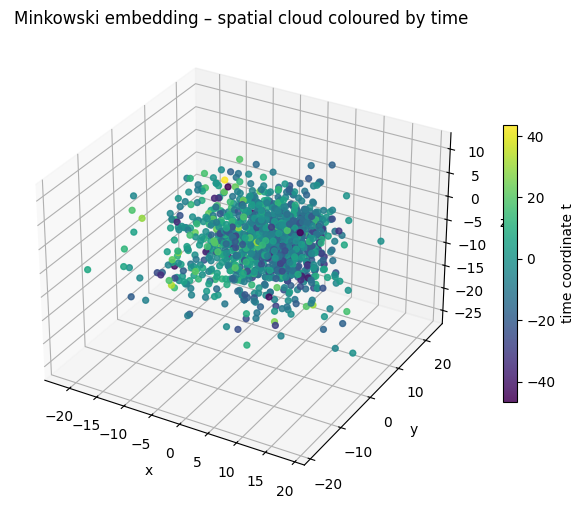

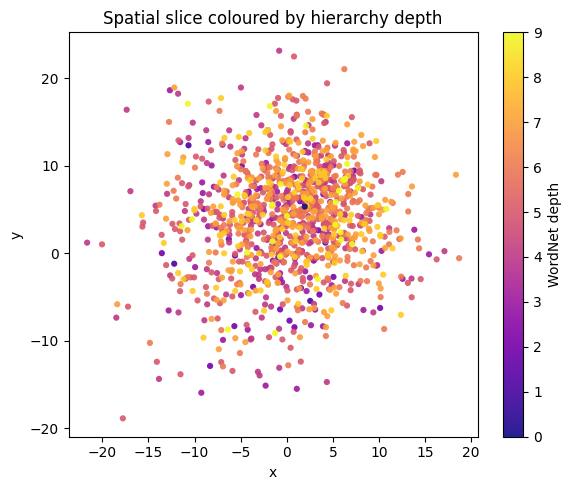


Depth 0:
  mammal
     ↳ placental
     ↳ metatherian
     ↳ prototherian
     ↳ tusker
     ↳ fossorial mammal
     ↳ female mammal

Depth 1:
  female mammal
  fossorial mammal
     ↳ naked mole rat
     ↳ Damaraland mole rat
  metatherian
     ↳ marsupial
  placental
     ↳ insectivore
     ↳ bat
     ↳ buck
     ↳ aquatic mammal
     ↳ primate
     ↳ doe
     ↳ cow
     ↳ yearling
     ↳ Unguiculata
     ↳ edentate
     ↳ ungulate
     ↳ flying lemur
     ↳ proboscidean
     ↳ tree shrew
     ↳ hyrax
     ↳ Ungulata
     ↳ rodent
     ↳ bull
     ↳ pangolin
     ↳ pachyderm
     ↳ carnivore
     ↳ plantigrade mammal
     ↳ aardvark
     ↳ livestock
     ↳ digitigrade mammal
     ↳ unguiculate
     ↳ lagomorph
     ↳ Fissipedia
  prototherian
     ↳ monotreme
  tusker

Depth 2:
  Damaraland mole rat
  Fissipedia
  Unguiculata
  Ungulata
  aardvark
  aquatic mammal
  bat
  buck
  bull
  carnivore
  cow
  digitigrade mammal
  doe
  edentate
  flying lemur
  hyrax
  insectivore
  lagom

In [ ]:
# ───────── VISUALISE THE FINAL EMBEDDING ─────────
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401  (enables 3-D)
import torch.nn.functional as F
import numpy as np

with torch.no_grad():
    xyz = F.linear(H, W_s).cpu().numpy()          # [V,3]
    t   = F.linear(H, w_t).cpu().numpy().ravel()  # [V]

# 3-D scatter ─ colour = learned time (t)
fig = plt.figure(figsize=(8,6))
ax  = fig.add_subplot(111, projection='3d')
sc  = ax.scatter(xyz[:,0], xyz[:,1], xyz[:,2],
                 c=t, cmap='viridis', s=18, alpha=0.85)
ax.set_xlabel('x'); ax.set_ylabel('y'); ax.set_zlabel('z')
fig.colorbar(sc, ax=ax, shrink=0.6, label='time coordinate t')
ax.set_title("Minkowski embedding – spatial cloud coloured by time")
plt.show()

# Optional 2-D slice (x,y) coloured by WordNet depth
plt.figure(figsize=(6,5))
plt.scatter(xyz[:,0], xyz[:,1], c=depth, cmap='plasma',
            s=20, alpha=0.9, edgecolors='none')
plt.xlabel("x"); plt.ylabel("y"); plt.colorbar(label="WordNet depth")
plt.title("Spatial slice coloured by hierarchy depth")
plt.tight_layout();  plt.show()

# --- TEXT VIEW OF THE ROOT AND ITS FIRST 2 LEVELS --------------
max_depth = 2
by_depth = {d:[] for d in range(max_depth+1)}
for i,d in enumerate(depth):
    if d<=max_depth:
        by_depth[d].append(i)

for d in range(max_depth+1):
    print(f"\nDepth {d}:")
    for i in sorted(by_depth[d], key=lambda k:names[k]):
        print(f"  {names[i]}")
        # show immediate children if we’re not at max depth yet
        if d < max_depth:
            kids = [ch for ch,pa in edges
                    if pa==i and depth[ch]==d+1]
            for k in kids:
                print(f"     ↳ {names[k]}")


In [ ]:
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4') # For other languages if needed
from nltk.corpus import wordnet as wn

import torch
from transformers import BertTokenizer, BertModel
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D # If we get to 3D plotting

# --- Configuration ---
BERT_MODEL_NAME = 'bert-base-uncased'
# For Minkowski Spacetime (from previous demos)
NUM_SPATIAL_DIMS = 2 # (x,y,t)
EPSILON_1 = 0.05 # For causal separation
EPSILON_2 = 0.0
MAX_ITERATIONS_EMBEDDING = 1000
LEARNING_RATE_FACTOR_EMBEDDING = 0.1

# --- Load BERT ---
print("Loading BERT model and tokenizer...")
tokenizer = BertTokenizer.from_pretrained(BERT_MODEL_NAME)
bert_model = BertModel.from_pretrained(BERT_MODEL_NAME)
bert_model.eval() # Set to evaluation mode
print("BERT loaded.")

# --- Helper function to get BERT embeddings ---
def get_bert_embedding(text, model, tokenizer):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)
    with torch.no_grad():
        outputs = model(**inputs)
    # Use the [CLS] token's representation for the whole sentence/concept
    return outputs.last_hidden_state[:, 0, :].squeeze().numpy()

# --- Load Mammal Subtree from WordNet (Simplified) ---
def get_mammal_concepts(depth_limit=3, start_synset_name='mammal.n.01'):
    concepts = {} # Store {name: {'synset': synset, 'depth': depth, 'parents': []}}

    try:
        mammal_root = wn.synset(start_synset_name)
    except:
        print(f"Error: Synset '{start_synset_name}' not found. Please check WordNet installation or name.")
        return {}

    queue = [(mammal_root, 0, None)] # (synset, depth, parent_name)
    visited_synsets = set()

    while queue:
        current_synset, depth, parent_name = queue.pop(0)

        if current_synset in visited_synsets or depth > depth_limit:
            continue
        visited_synsets.add(current_synset)

        name = current_synset.lemmas()[0].name().replace('_', ' ') # Use first lemma name

        if name not in concepts:
            concepts[name] = {'synset': current_synset, 'depth': depth, 'parents': set(), 'children': set()}

        if parent_name:
            concepts[name]['parents'].add(parent_name)
            if parent_name in concepts: # Should be
                 concepts[parent_name]['children'].add(name)


        for hyponym in current_synset.hyponyms():
            queue.append((hyponym, depth + 1, name))

    # Filter out concepts that might be too abstract or have no connections in our subset
    # For simplicity, just return all collected
    return concepts

print("Loading mammal concepts from WordNet...")
mammal_concepts_data = get_mammal_concepts(depth_limit=2) # Keep it small for demo
if not mammal_concepts_data:
    print("No mammal concepts loaded. Demo cannot proceed with WordNet part.")
else:
    print(f"Loaded {len(mammal_concepts_data)} mammal-related concepts.")
    # for name, data in list(mammal_concepts_data.items())[:5]:
    #     print(f"- {name} (Depth: {data['depth']}, Parents: {data['parents']})")

# Get BERT embeddings for these concepts
mammal_embeddings = {}
if mammal_concepts_data:
    print("\nGenerating BERT embeddings for mammal concepts...")
    for name, data in mammal_concepts_data.items():
        mammal_embeddings[name] = get_bert_embedding(name, bert_model, tokenizer)
    print(f"Generated {len(mammal_embeddings)} embeddings.")

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


Loading BERT model and tokenizer...
BERT loaded.
Loading mammal concepts from WordNet...
Loaded 39 mammal-related concepts.

Generating BERT embeddings for mammal concepts...
Generated 39 embeddings.


In [ ]:
def find_convergent_concepts(parent_name, concepts_data, embeddings, similarity_threshold=0.7):
    """
    Identifies children of parent_name that are "convergent" by being similar
    to many of their siblings. This is a proxy for Pichat's idea.
    """
    if parent_name not in concepts_data or not concepts_data[parent_name]['children']:
        return []

    children_names = list(concepts_data[parent_name]['children'])
    if len(children_names) < 2: # Need at least two children to compare
        return children_names # Or [] if we require convergence among multiple

    convergent_children = []
    for child_name in children_names:
        if child_name not in embeddings: continue
        child_emb = embeddings[child_name].reshape(1, -1)

        num_similar_siblings = 0
        for sibling_name in children_names:
            if sibling_name == child_name or sibling_name not in embeddings:
                continue
            sibling_emb = embeddings[sibling_name].reshape(1, -1)
            similarity = cosine_similarity(child_emb, sibling_emb)[0, 0]
            if similarity > similarity_threshold:
                num_similar_siblings += 1

        # Define convergence: e.g., similar to at least half of its siblings (or a fixed number)
        # This is a heuristic for "intersection of sub-dimensions"
        if len(children_names) > 1 and num_similar_siblings >= (len(children_names) -1 ) / 2: # Arbitrary threshold
             # Or: if num_similar_siblings > some_fixed_number (e.g., 2 if many children)
            convergent_children.append(child_name)
            print(f"  '{child_name}' is convergent for parent '{parent_name}' (similar to {num_similar_siblings} siblings).")

    return convergent_children

# --- Identify potentially "stable/meaningful" (convergent) entities ---
stable_entities_for_hierarchy = set()
if mammal_concepts_data:
    print("\nIdentifying convergent concepts (proxy for stability/monosemy):")
    # Always include the root
    root_mammal = 'mammal' # Assuming 'mammal.n.01' first lemma is 'mammal'
    if root_mammal in mammal_concepts_data:
        stable_entities_for_hierarchy.add(root_mammal)

    for concept_name in mammal_concepts_data.keys():
        # Here, 'concept_name' acts as a potential "category" (like Pichat's neuron).
        # Its children are like "tokens" or "sub-dimensions" it considers.
        # We look for children that are central/convergent among their siblings.
        convergent_children = find_convergent_concepts(concept_name, mammal_concepts_data, mammal_embeddings)
        for conv_child in convergent_children:
            stable_entities_for_hierarchy.add(conv_child)

        # Also, consider parent concepts themselves as relatively stable if they have convergent children
        if convergent_children:
            stable_entities_for_hierarchy.add(concept_name)


    # For this demo, let's ensure parents of stable entities are also included up to the root
    # This helps build a connected hierarchy for spacetime embedding
    print(f"\nInitial stable entities ({len(stable_entities_for_hierarchy)}): {stable_entities_for_hierarchy}")

    # Build a more coherent set for hierarchy embedding
    final_hierarchy_nodes = set(stable_entities_for_hierarchy)
    nodes_to_process = list(stable_entities_for_hierarchy)

    while nodes_to_process:
        current_node = nodes_to_process.pop(0)
        if current_node in mammal_concepts_data:
            for parent in mammal_concepts_data[current_node]['parents']:
                if parent not in final_hierarchy_nodes and parent in mammal_concepts_data: # Ensure parent is in our dataset
                    final_hierarchy_nodes.add(parent)
                    nodes_to_process.append(parent) # Process this parent's parents too

    print(f"Final set of nodes for spacetime hierarchy ({len(final_hierarchy_nodes)}): {final_hierarchy_nodes}")

    if not final_hierarchy_nodes:
        print("No stable entities found or root not included. Spacetime demo part might not work well.")


Identifying convergent concepts (proxy for stability/monosemy):
  'fossorial mammal' is convergent for parent 'mammal' (similar to 5 siblings).
  'tusker' is convergent for parent 'mammal' (similar to 5 siblings).
  'metatherian' is convergent for parent 'mammal' (similar to 5 siblings).
  'placental' is convergent for parent 'mammal' (similar to 5 siblings).
  'female mammal' is convergent for parent 'mammal' (similar to 5 siblings).
  'prototherian' is convergent for parent 'mammal' (similar to 5 siblings).
  'tree shrew' is convergent for parent 'placental' (similar to 27 siblings).
  'pangolin' is convergent for parent 'placental' (similar to 27 siblings).
  'bat' is convergent for parent 'placental' (similar to 26 siblings).
  'unguiculate' is convergent for parent 'placental' (similar to 27 siblings).
  'proboscidean' is convergent for parent 'placental' (similar to 27 siblings).
  'digitigrade mammal' is convergent for parent 'placental' (similar to 27 siblings).
  'primate' is


Stable hierarchy root: mammal
Generated 39 parent-child pairs for stable hierarchy.

Starting embedding adjustment for STABLE hierarchy...
Iter 0: Violations=38, DeltaSum=25.7494
Iter 100: Violations=38, DeltaSum=0.0063
Iter 200: Violations=38, DeltaSum=0.0000
Iter 300: Violations=38, DeltaSum=0.0000
Iter 400: Violations=38, DeltaSum=0.0000
Iter 500: Violations=38, DeltaSum=0.0000
Iter 600: Violations=38, DeltaSum=0.0000
Iter 700: Violations=38, DeltaSum=0.0000
Iter 800: Violations=38, DeltaSum=0.0000
Iter 900: Violations=38, DeltaSum=0.0000
Max iterations reached for stable hierarchy embedding.


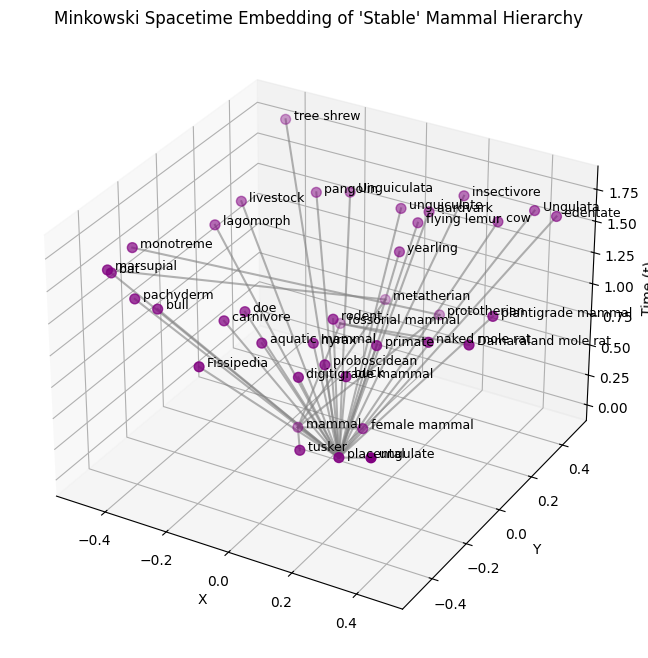

In [ ]:
# --- Spacetime Embedding Part (using functions from previous demos) ---
# Ensure these are defined from previous cells:
# - minkowski_interval_sq, spatial_distance_sq, is_causally_connected
# - The simplified iterative embedding adjustment loop

if final_hierarchy_nodes:
    # Create (child, parent) pairs for the selected stable entities
    hierarchy_pairs_stable = []
    # Determine the root for the stable hierarchy (should be 'mammal' or highest ancestor)
    stable_root_node = None
    min_depth = float('inf')

    for node_name in final_hierarchy_nodes:
        if node_name in mammal_concepts_data:
            if mammal_concepts_data[node_name]['depth'] < min_depth:
                min_depth = mammal_concepts_data[node_name]['depth']
                stable_root_node = node_name

            for parent_name in mammal_concepts_data[node_name]['parents']:
                if parent_name in final_hierarchy_nodes: # Only include edges between selected nodes
                    hierarchy_pairs_stable.append((node_name, parent_name))

    if stable_root_node:
        hierarchy_pairs_stable.append((stable_root_node, None)) # Add root
        print(f"\nStable hierarchy root: {stable_root_node}")
    else:
        print("Could not determine root for stable hierarchy. Proceeding without explicit root edge.")


    # Remove duplicates that might arise if root is added multiple times
    hierarchy_pairs_stable = sorted(list(set(hierarchy_pairs_stable)))
    print(f"Generated {len(hierarchy_pairs_stable)} parent-child pairs for stable hierarchy.")

    # --- Setup for Minkowski Embedding ---
    nodes_stable_h = sorted(list(final_hierarchy_nodes))
    if not nodes_stable_h:
        print("No nodes in stable hierarchy. Cannot proceed with embedding.")
    else:
        node_to_id_stable_h = {name: i for i, name in enumerate(nodes_stable_h)}
        id_to_node_stable_h = {i: name for i, name in enumerate(nodes_stable_h)}
        num_nodes_stable_h = len(nodes_stable_h)

        adj_stable_h = {}
        for child, parent in hierarchy_pairs_stable:
            if parent is not None:
                if child in node_to_id_stable_h and parent in node_to_id_stable_h:
                    adj_stable_h[node_to_id_stable_h[child]] = node_to_id_stable_h[parent]

        root_id_stable_h = node_to_id_stable_h.get(stable_root_node) if stable_root_node else None

        # --- Run Embedding ---
        coords_stable_h = np.random.rand(num_nodes_stable_h, NUM_SPATIAL_DIMS + 1) * 0.5 - 0.25
        coords_stable_h[:, :-1] = np.random.uniform(-0.5, 0.5, size=(num_nodes_stable_h, NUM_SPATIAL_DIMS))
        coords_stable_h[:, -1] = 0.0

        print("\nStarting embedding adjustment for STABLE hierarchy...")
        for iteration in range(MAX_ITERATIONS_EMBEDDING):
            violations = 0
            total_delta_sum = 0
            for child_id, parent_id in adj_stable_h.items():
                child_coord = coords_stable_h[child_id]
                parent_coord = coords_stable_h[parent_id]
                t_child, t_parent = child_coord[-1], parent_coord[-1]
                d_xy_spatial = np.sqrt(spatial_distance_sq(child_coord, parent_coord))
                t_xy_current = t_child - t_parent
                t_min_required = d_xy_spatial + EPSILON_1
                if t_xy_current < t_min_required:
                    violations += 1
                    delta_t = t_min_required - t_xy_current
                    total_delta_sum += delta_t
                    coords_stable_h[child_id, -1] += delta_t * (1 - EPSILON_2) * LEARNING_RATE_FACTOR_EMBEDDING
                    # Parent adjustment (if EPSILON_2 > 0) ...
            if iteration % 100 == 0:
                print(f"Iter {iteration}: Violations={violations}, DeltaSum={total_delta_sum:.4f}")
            if violations == 0 and total_delta_sum < 1e-6:
                print(f"Converged at iter {iteration} for stable hierarchy.")
                break
        else:
            print("Max iterations reached for stable hierarchy embedding.")

        if num_nodes_stable_h > 0: # Check if there are any coordinates to process
            min_time_val = np.min(coords_stable_h[:, -1]) if coords_stable_h.size > 0 else 0
            coords_stable_h[:, -1] -= min_time_val

        # --- Visualization ---
        fig_stable = plt.figure(figsize=(10, 8))
        ax_stable = fig_stable.add_subplot(111, projection='3d' if NUM_SPATIAL_DIMS >= 2 else None)

        if NUM_SPATIAL_DIMS >= 2:
            ax_stable.scatter(coords_stable_h[:, 0], coords_stable_h[:, 1], coords_stable_h[:, -1], c='purple', s=50)
            for i in range(num_nodes_stable_h):
                ax_stable.text(coords_stable_h[i, 0], coords_stable_h[i, 1], coords_stable_h[i, -1],
                            f"  {id_to_node_stable_h[i]}", size=9)
            for child_id, parent_id in adj_stable_h.items():
                p1, p2 = coords_stable_h[parent_id], coords_stable_h[child_id]
                ax_stable.plot([p1[0], p2[0]], [p1[1], p2[1]], [p1[-1], p2[-1]], c='gray', alpha=0.6)
            ax_stable.set_xlabel("X"); ax_stable.set_ylabel("Y"); ax_stable.set_zlabel("Time (t)")
        elif NUM_SPATIAL_DIMS == 1: # 2D plot for (x,t)
            ax_stable.scatter(coords_stable_h[:, 0], coords_stable_h[:, -1], c='purple', s=50)
            for i in range(num_nodes_stable_h):
                ax_stable.text(coords_stable_h[i, 0], coords_stable_h[i, -1],
                            f"  {id_to_node_stable_h[i]}", size=9)
            for child_id, parent_id in adj_stable_h.items():
                p1, p2 = coords_stable_h[parent_id], coords_stable_h[child_id]
                ax_stable.plot([p1[0], p2[0]], [p1[-1], p2[-1]], c='gray', alpha=0.6)
            ax_stable.set_xlabel("X"); ax_stable.set_ylabel("Time (t)")


        plt.title("Minkowski Spacetime Embedding of 'Stable' Mammal Hierarchy")
        plt.show()

else:
    print("No stable entities identified, skipping spacetime embedding part for this demo.")